In [4]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
# os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
#from scipy.signal import argrelextrema                      # Find local Maxima-Minima in numpy array
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

### Functions declaration

In [5]:
def detrend_dim(da, dim, degree):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    da_det = (da - fit)
    return da_det
def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def xr_mean_list(xr_list, nc_files):
    ## Function for calculate the mean response of several simulations from different ESM
    # xr_list: list of xarray, each representing one simulation 
    # nc_files: list of NetCDF opened with nc.Dataset(), containing data and attributes
    # returns an xr_list_new with one element for each esm 

    # List of ESM names in every simulation
    esm = [a.source_id for a in nc_files]
    # esm = [nc_files]#

    # Assign as a new coordinate ESM name
    xr_list = [a.assign_coords(esm=b) for a,b in zip(xr_list,esm)]

    # List of unique ESM names sorted
    esm = list(set(esm))
    esm.sort()

    # Create a list of the different esm lists
    access = []; bcc = []; cesm = []; cmcc = []; cnrm = []; canesm = []; e3sm = []; ipsl = []; miroc = []; mpi = []; noresm = []; taiesm = []; ukesm = []
    esm_list = [access, bcc, cesm, cmcc, cnrm, canesm, e3sm, ipsl, miroc, mpi, noresm, taiesm, ukesm]

    # populate the esm_list according to xr.coords["esm"]
    for e,model in enumerate(esm):
        for i,xarray in enumerate(xr_list):
            esm_coord = xarray.coords["esm"]
            if esm_coord == esm[e]:
                esm_list[e].append(xarray)

    # take the mean of all the xarray belonging to the same esm
    xr_list_new = []
    for e in esm_list:
        content = xr.concat(e, dim='realiz')
        content1 = content.mean(dim = "realiz")
        xr_list_new.append(content1)
    
    return xr_list_new

## Fuction for subsetting colormap values ## 
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope
    y_pred =  intercept + slope*x
    res = y - y_pred

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    #return cov,cor,slope,intercept,pval,stderr
    return res

def cor_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #return cov,cor,slope,intercept,pval,stderr
    return cor

def xr_multipletest(p, alpha=0.05, method='fdr_bh', **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests
    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected


### Open SST data

In [6]:
##### ------- Open data (MODEL) ------- #####
data_path = 'C:/Users/mastr/Documents/Amazon'
scenario = 'historical'
files = "nino34" + '_*_' + scenario + '_*'

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/ENSO/detrended/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)   

nino34_hist = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/ENSO/detrended/'+files))):               # sorted is case sensitive                             ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #content = content.mean(dim="time")         ## values   var     dims    coords
    nino34_hist.append(content)

scenario = 'ssp585'
files = "nino34" + '_*_' + scenario + '_*' 

nino34_ssp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/ENSO/detrended/'+files))):               # sorted is case sensitive                             ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #content = content.mean(dim="time")         ## values   var     dims    coords
    nino34_ssp.append(content)

# Standardize calendar 
# for i, item in enumerate(nino34_hist):
#     if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
#         nino34_hist[i]['time'] = item.indexes['time'].to_datetimeindex()
    
# for i, item in enumerate(nino34_ssp):
#     if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
#         nino34_ssp[i]['time'] = item.indexes['time'].to_datetimeindex()

## Normalization
for i,item in enumerate(nino34_hist):
    nino34_hist[i] =  ((nino34_hist[i] - (nino34_hist[i].mean(dim='time'))).compute()/(nino34_hist[i].std(dim='time'))).compute()

for i,item in enumerate(nino34_ssp):
    nino34_ssp[i] =  ((nino34_ssp[i] - (nino34_ssp[i].mean(dim='time'))).compute()/(nino34_hist[i].std(dim='time'))).compute()


## Resample from Monthly to seasonal timesteps
nino34_hist_seas = []
for i,item in enumerate(nino34_hist):
    content = item.resample(time="QS", label='left').mean()
    nino34_hist_seas.append(content)

nino34_ssp_seas = []
for i,item in enumerate(nino34_ssp):
    content = item.resample(time="QS", label='left').mean()
    nino34_ssp_seas.append(content)

### Open LAND data

In [7]:
data_path = 'F:/Data/analysis/'              

var_name = "nep"
scenario = 'historical'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)   

ds_hist_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_hist_nep.append(content)    

for i, item in enumerate(ds_hist_nep):    
    ds_hist_nep[i] = ds_hist_nep[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_nep[i] = ds_hist_nep[i].sel(time = slice("1850-01", "2014-12"))
    ds_hist_nep[i] = ds_hist_nep[i].sel(lat=slice(-30,30), lon=slice(260,340))
    ds_hist_nep[i] = ds_hist_nep[i].resample(time="QS", label='left').mean()
    if ds_hist_nep[i]['time'].dt.calendar == 'noleap' or ds_hist_nep[i]['time'].dt.calendar == '360_day':
        ds_hist_nep[i]['time'] = ds_hist_nep[i].indexes['time'].to_datetimeindex()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_hist_nep[i] = ds_hist_nep[i].where(ds_hist_nep[i] != -6.18386321e-06)
    if files_list[i].source_id == "CESM2-WACCM":
        ds_hist_nep[i] = ds_hist_nep[i]*-1
        ds_hist_nep[i] = ds_hist_nep[i].assign_attrs(esm=files_list[i].source_id)
    if files_list[i].source_id == "UKESM1-0-LL":
        ds_hist_nep[i]["time"] = ds_hist_nep[0]["time"]



In [8]:
data_path = 'F:/Data/analysis/'              
var_name = 'nep'
scenario = 'ssp585-rad'
files = var_name + '_*_ssp585_'  + '*_net.nc' 

ds_ssp_nep_net = []
for filepath in sorted(glob.glob(os.path.join(data_path+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_nep_net.append(content)                                                                 

##### ------- UNIFORM CALENDAR ------- #####
for i, item in enumerate(ds_ssp_nep_net):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_nep_net[i]['time'] = item.indexes['time'].to_datetimeindex()

ds_ssp_nep_net = [a.resample(time="QS", label='left').mean() for a in ds_ssp_nep_net]

# ds_ssp_nep_net = []
# for i, item in enumerate(ds_ssp_nep_net):
#     content = item.rolling(time = 6).mean()                # Compute 7 months running mean
#     content1 = content[content.time.dt.month == 3]     # Select March to get the average over SONDJFM
#     ds_ssp_nep_net.append(content1)

# CanESM5 hist and ssp have numeric values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(ds_ssp_nep_net):
    if ds_ssp_nep_net[i].esm == "CanESM5":
        ds_ssp_nep_net[i] = ds_ssp_nep_net[i].where(ds_ssp_nep_net[i] != -3.7270379e-07)
        ds_ssp_nep_net[i] = ds_ssp_nep_net[i].where(ds_ssp_nep_net[i] != -6.18386321e-06)

In [9]:
data_path = 'F:/Data/analysis/'              

scenario = 'historical'
var_name = 'pr'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_pr = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    content = content.assign_attrs(esm = nc.Dataset(filepath).source_id)
    ds_hist_pr.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_pr = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    content = content.assign_attrs(esm = nc.Dataset(filepath).source_id)
    ds_ssp_pr.append(content)    

# Uniform calendar
for i, item in enumerate(ds_hist_pr):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_pr[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_pr):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_pr[i]['time'] = item.indexes['time'].to_datetimeindex()

# Subsetting latitude
ds_hist_pr = [a.sel(lat=slice(-30,30), lon=slice(260,340)) for a in ds_hist_pr]
ds_ssp_pr = [a.sel(lat=slice(-30,30), lon=slice(260,340)) for a in ds_ssp_pr]

# Resample from months to seasons
ds_hist_pr = [a.resample(time="QS", label='left').mean() for a in ds_hist_pr]
ds_ssp_pr = [a.resample(time="QS", label='left').mean() for a in ds_ssp_pr]

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i] == "CanESM5":
        ds_hist_pr[i] = ds_hist_pr[i].where(ds_hist_pr[i] != -3.7270379e-07)
        ds_ssp_pr[i] = ds_ssp_pr[i].where(ds_ssp_pr[i] != -6.18386321e-06)

In [10]:
data_path = 'F:/Data/analysis/'              

scenario = 'historical'
var_name = 'tas'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_tas = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    content = content.assign_attrs(esm = nc.Dataset(filepath).source_id)
    ds_hist_tas.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_tas = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    content = content.assign_attrs(esm = nc.Dataset(filepath).source_id)
    ds_ssp_tas.append(content)    

# Uniform calendar
for i, item in enumerate(ds_hist_tas):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_tas[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_tas):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_tas[i]['time'] = item.indexes['time'].to_datetimeindex()

# Subsetting latitude
ds_hist_tas = [a.sel(lat=slice(-30,30), lon=slice(260,340)) for a in ds_hist_tas]
ds_ssp_tas = [a.sel(lat=slice(-30,30), lon=slice(260,340)) for a in ds_ssp_tas]

# Resample from months to seasons
ds_hist_tas = [a.resample(time="QS", label='left').mean() for a in ds_hist_tas]
ds_ssp_tas = [a.resample(time="QS", label='left').mean() for a in ds_ssp_tas]

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i] == "CanESM5":
        ds_hist_tas[i] = ds_hist_tas[i].where(ds_hist_tas[i] != -3.7270379e-07)
        ds_ssp_tas[i] = ds_ssp_tas[i].where(ds_ssp_tas[i] != -6.18386321e-06)

In [11]:
data_path = 'F:/Data/analysis/'              

scenario = 'historical'
var_name = 'mrso'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_mrso = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    content = content.assign_attrs(esm = nc.Dataset(filepath).source_id)
    ds_hist_mrso.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_mrso = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    content = content.assign_attrs(esm = nc.Dataset(filepath).source_id)
    ds_ssp_mrso.append(content)    

# Subsetting latitude
ds_hist_mrso = [a.sel(lat=slice(-30,30), lon=slice(260,340)) for a in ds_hist_mrso]
ds_ssp_mrso = [a.sel(lat=slice(-30,30), lon=slice(260,340)) for a in ds_ssp_mrso]

# Uniform calendar
for i, item in enumerate(ds_hist_mrso):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_mrso[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_mrso):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_mrso[i]['time'] = item.indexes['time'].to_datetimeindex()

# Resample from months to seasons
ds_hist_mrso = [a.resample(time="QS", label='left').mean() for a in ds_hist_mrso]
ds_ssp_mrso = [a.resample(time="QS", label='left').mean() for a in ds_ssp_mrso]


In [12]:
data_path = 'F:/Data/analysis/'              

scenario = 'historical'
var_name = 'rsds'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_rsds = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    content = content.assign_attrs(esm = nc.Dataset(filepath).source_id)
    ds_hist_rsds.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_rsds = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    content = content.assign_attrs(esm = nc.Dataset(filepath).source_id)
    ds_ssp_rsds.append(content)    

# Subsetting latitude
ds_hist_rsds = [a.sel(lat=slice(-30,30), lon=slice(260,340)) for a in ds_hist_rsds]
ds_ssp_rsds = [a.sel(lat=slice(-30,30), lon=slice(260,340)) for a in ds_ssp_rsds]

# Uniform calendar
for i, item in enumerate(ds_hist_rsds):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_rsds[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_rsds):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_rsds[i]['time'] = item.indexes['time'].to_datetimeindex()

# Resample from months to seasons
ds_hist_rsds = [a.resample(time="QS", label='left').mean() for a in ds_hist_rsds]
ds_ssp_rsds = [a.resample(time="QS", label='left').mean() for a in ds_ssp_rsds]


In [13]:
data_path = 'F:/Data/analysis/'              

scenario = 'historical'
var_name = 'hfls'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_hfls = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    content = content.assign_attrs(esm = nc.Dataset(filepath).source_id)
    ds_hist_hfls.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_hfls = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    content = content.assign_attrs(esm = nc.Dataset(filepath).source_id)
    ds_ssp_hfls.append(content)    

# Subsetting latitude
ds_hist_hfls = [a.sel(lat=slice(-30,30), lon=slice(260,340)) for a in ds_hist_hfls]
ds_ssp_hfls = [a.sel(lat=slice(-30,30), lon=slice(260,340)) for a in ds_ssp_hfls]

# Uniform calendar
for i, item in enumerate(ds_hist_hfls):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_hfls[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_hfls):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_hfls[i]['time'] = item.indexes['time'].to_datetimeindex()

# Resample from months to seasons
ds_hist_hfls = [a.resample(time="QS", label='left').mean() for a in ds_hist_hfls]
ds_ssp_hfls = [a.resample(time="QS", label='left').mean() for a in ds_ssp_hfls]


Delete not common models

In [14]:
ds_hist_nep = [item for item in ds_hist_nep if item.esm not in {"BCC-CSM2-MR", "E3SM-1-1-ECA", "TaiESM1", "NorESM2-MM"}]
ds_hist_pr = [item for item in ds_hist_pr if item.esm not in {"BCC-CSM2-MR", "E3SM-1-1-ECA", "TaiESM1", "NorESM2-MM"}]
ds_ssp_pr = [item for item in ds_ssp_pr if item.esm not in {"BCC-CSM2-MR", "E3SM-1-1-ECA", "TaiESM1", "NorESM2-MM"}]
ds_hist_mrso = [item for item in ds_hist_mrso if item.esm not in {"BCC-CSM2-MR", "E3SM-1-1-ECA", "TaiESM1", "NorESM2-MM"}]
ds_ssp_mrso = [item for item in ds_ssp_mrso if item.esm not in {"BCC-CSM2-MR", "E3SM-1-1-ECA", "TaiESM1", "NorESM2-MM"}]
ds_hist_hfls = [item for item in ds_hist_hfls if item.esm not in {"BCC-CSM2-MR", "E3SM-1-1-ECA", "TaiESM1", "NorESM2-MM"}]
ds_ssp_hfls = [item for item in ds_ssp_hfls if item.esm not in {"BCC-CSM2-MR", "E3SM-1-1-ECA", "TaiESM1", "NorESM2-MM"}]
ds_hist_rsds = [item for item in ds_hist_rsds if item.esm not in {"BCC-CSM2-MR", "E3SM-1-1-ECA", "TaiESM1", "NorESM2-MM"}]
ds_ssp_rsds = [item for item in ds_ssp_rsds if item.esm not in {"BCC-CSM2-MR", "E3SM-1-1-ECA", "TaiESM1", "NorESM2-MM"}]
ds_hist_tas = [item for item in ds_hist_tas if item.esm not in {"BCC-CSM2-MR", "E3SM-1-1-ECA", "TaiESM1", "NorESM2-MM"}]
ds_ssp_tas = [item for item in ds_ssp_tas if item.esm not in {"BCC-CSM2-MR", "E3SM-1-1-ECA", "TaiESM1", "NorESM2-MM"}]

In [15]:
esm = []
for i,item in enumerate(ds_hist_nep):
    esm.append(item.esm)
print(esm)

['ACCESS-ESM1-5', 'ACCESS-ESM1-5', 'ACCESS-ESM1-5', 'ACCESS-ESM1-5', 'ACCESS-ESM1-5', 'CESM2-WACCM', 'CESM2-WACCM', 'CESM2-WACCM', 'CMCC-ESM2', 'CNRM-ESM2-1', 'CNRM-ESM2-1', 'CNRM-ESM2-1', 'CNRM-ESM2-1', 'CNRM-ESM2-1', 'CanESM5', 'CanESM5', 'CanESM5', 'CanESM5', 'CanESM5', 'IPSL-CM6A-LR', 'IPSL-CM6A-LR', 'IPSL-CM6A-LR', 'IPSL-CM6A-LR', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC-ES2L', 'MIROC-ES2L', 'MIROC-ES2L', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM', 'UKESM1-0-LL', 'UKESM1-0-LL', 'UKESM1-0-LL', 'UKESM1-0-LL', 'UKESM1-0-LL']


### Correct for lon lat mishape and values

for i,item in enumerate(ds_hist_nep):
    if item.esm == "UKESM1-0-LL":
        ds_hist_pr[i] = ds_hist_pr[i].isel(lon = slice(0,191));  ds_ssp_pr[i] = ds_ssp_pr[i].isel(lon = slice(0,191))
        # Correct pr hist UKESM from lon:192 to lon:191
        ds_hist_nep[i] = ds_hist_nep[i].isel(lon = slice(0,191)); ds_ssp_nep[i] = ds_ssp_nep[i].isel(lon = slice(0,191))
        ds_hist_rsds[i] = ds_hist_rsds[i].isel(lon = slice(0,191)); ds_ssp_rsds[i] = ds_ssp_rsds[i].isel(lon = slice(0,191))
        ds_hist_tas[i] = ds_hist_tas[i].isel(lon = slice(0,191)); ds_ssp_tas[i] = ds_ssp_tas[i].isel(lon = slice(0,191))
        ds_hist_mrso[i] = ds_hist_mrso[i].isel(lon = slice(0,191)); ds_ssp_mrso[i] = ds_ssp_mrso[i].isel(lon = slice(0,191))

In [16]:
# Correct the number of longitude points
ds_hist_nep = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_nep, ds_hist_pr)]
ds_hist_mrso = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_mrso, ds_hist_pr)]
ds_hist_tas = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_tas, ds_hist_pr)]
ds_hist_rsds = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_rsds, ds_hist_pr)]
ds_hist_hfls = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_hfls, ds_hist_pr)]
ds_ssp_hfls = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_hfls, ds_ssp_pr)]
ds_ssp_rsds = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_rsds, ds_ssp_pr)]
# ds_ssp_nep = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_nep, ds_ssp_pr)]
ds_ssp_mrso = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_mrso, ds_ssp_pr)]
ds_ssp_tas = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_tas, ds_ssp_pr)]
ds_ssp_nep_net = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_nep_net, ds_hist_pr)]

# Assign the exactly same set of coordinates to ALL the dataarray (avoid duplication due to numerical approximation of lon lat)
ds_hist_pr = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_pr,ds_hist_nep)]
ds_hist_tas = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_tas,ds_hist_nep)]
ds_hist_mrso = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_mrso,ds_hist_nep)]
ds_hist_rsds = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_rsds,ds_hist_nep)]
ds_hist_hfls = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_hfls,ds_hist_nep)]
ds_ssp_hfls = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_hfls,ds_ssp_nep_net)]
ds_ssp_rsds = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_rsds,ds_ssp_nep_net)]
ds_ssp_pr = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_pr,ds_ssp_nep_net)]
ds_ssp_tas = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_tas,ds_ssp_nep_net)]
ds_ssp_mrso = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_mrso,ds_ssp_nep_net)]


### Composites HISTORICAL

Define Nino events as those DJF seasons lying above 90th perc\
Define Nina events as those DJF seasons lying below 10th perc\
Define Mean State conditions as those DJF seasons in between

Percentiles calculated in the historical scenario (1901-1960) and in the ssp scenario (2040-2100) so that to have the same number of events

In [17]:
seas = "DJF"

def composite_analysis(ds, ds_sst, quant1, quant2, time_init, time_end):
    perc90 = ds_sst.sel(time = ds_sst.time.dt.season==seas).sel(time = slice(time_init,time_end)).quantile(quant1, dim = 'time')      # Percentile only from the DJF season
    perc10 = ds_sst.sel(time = ds_sst.time.dt.season==seas).sel(time = slice(time_init,time_end)).quantile(quant2, dim = 'time')
    # perc90 = ds_sst.sel(time = slice(time_init,time_end)).quantile(quant1, dim = 'time')      # Percentile only from the SONDJFM season
    # perc10 = ds_sst.sel(time = slice(time_init,time_end)).quantile(quant2, dim = 'time')
    nino_events = ds.sel(time = ds.time.dt.season==seas).sel(time = slice(time_init,time_end)).where(ds_sst > perc90, drop=True)
    nina_events = ds.sel(time = ds.time.dt.season==seas).sel(time = slice(time_init,time_end)).where(ds_sst < perc10, drop=True)
    # nino_events = ds.sel(time = slice(time_init,time_end)).where(ds_sst > perc90, drop=True)
    # nina_events = ds.sel(time = slice(time_init,time_end)).where(ds_sst < perc10, drop=True)
    ds_nino = ds.sel(time = nino_events.time, method ="nearest").sel(time = slice(time_init,time_end))  
    ds_nina = ds.sel(time = nina_events.time, method ="nearest").sel(time = slice(time_init,time_end))          
    ds_nino = ds_nino.mean(dim = "time")        # Composites of El Nino
    ds_nina = ds_nina.mean(dim = "time")        # Composites of La Nina
    content = ds.sel(time = ds.time.dt.season==seas).sel(time=slice(time_init,time_end))
    # content = ds.sel(time=slice(time_init,time_end))
    content1 = nino_events.groupby(nino_events.time.dt.year).mean("time")  # NINO events between 1901 an6 1910
    content2 = nina_events.groupby(nina_events.time.dt.year).mean("time")  # NINO events between 1901 an6 1910
    for ninoyrs in np.array(content1.year):                                                                            # drop NINO events'years recursively
        content = content.where(content.time.dt.year != ninoyrs, drop = True)
    for ninayrs in np.array(content2.year):
        content = content.where(content.time.dt.year != ninayrs, drop = True)                                          # drop NINO events'years recursively   
    ds_clim_neutral = content.mean(dim="time")  # Composites of mean state changes (Neutral years)

    ds_nino = ds_nino.assign_attrs(esm = ds.esm)
    ds_nina = ds_nina.assign_attrs(esm = ds.esm)
    ds_clim_neutral = ds_clim_neutral.assign_attrs(esm = ds.esm)
    return ds_clim_neutral, ds_nino, ds_nina



In [18]:
results_hist_nep = [composite_analysis(a, b, 0.9, 0.1, "1901", "1960") for a,b in zip(ds_hist_nep, nino34_hist_seas)]
results_hist_pr = [composite_analysis(a, b, 0.9, 0.1, "1901", "1960") for a,b in zip(ds_hist_pr, nino34_hist_seas)]
results_hist_mrso  = [composite_analysis(a, b, 0.9, 0.1, "1901", "1960") for a,b in zip(ds_hist_mrso, nino34_hist_seas)]
results_hist_tas = [composite_analysis(a, b, 0.9, 0.1, "1901", "1960") for a,b in zip(ds_hist_tas, nino34_hist_seas)]
results_hist_rsds  = [composite_analysis(a, b, 0.9, 0.1, "1901", "1960") for a,b in zip(ds_hist_rsds, nino34_hist_seas)]
results_hist_hfls  = [composite_analysis(a, b, 0.9, 0.1, "1901", "1960") for a,b in zip(ds_hist_hfls, nino34_hist_seas)]

In [19]:
results_ssp_nep_net = [composite_analysis(a, b, 0.9, 0.1, "2041", "2100") for a,b in zip(ds_ssp_nep_net, nino34_ssp_seas)]
results_ssp_pr = [composite_analysis(a, b, 0.9, 0.1, "2041", "2100") for a,b in zip(ds_ssp_pr, nino34_ssp_seas)]
results_ssp_mrso  = [composite_analysis(a, b, 0.9, 0.1, "2041", "2100") for a,b in zip(ds_ssp_mrso, nino34_ssp_seas)]
results_ssp_tas = [composite_analysis(a, b, 0.9, 0.1, "2041", "2100") for a,b in zip(ds_ssp_tas, nino34_ssp_seas)]
results_ssp_rsds  = [composite_analysis(a, b, 0.9, 0.1, "2041", "2100") for a,b in zip(ds_ssp_rsds, nino34_ssp_seas)]
results_ssp_hfls  = [composite_analysis(a, b, 0.9, 0.1, "2041", "2100") for a,b in zip(ds_ssp_hfls, nino34_ssp_seas)]

In [136]:
## -- Save and export Composites list data
import pickle

data_path = 'G:/Shared drives/Amazon_ENSO_work'

with open(os.path.join(data_path+"/analysis/Composites_nep_hist_net"), "wb") as fp:   #Pickling
    pickle.dump(results_hist_nep, fp)

with open(os.path.join(data_path+"/analysis/Composites_pr_hist_net"), "wb") as fp:   #Pickling
    pickle.dump(results_hist_pr, fp)

with open(os.path.join(data_path+"/analysis/Composites_mrso_hist_net"), "wb") as fp:   #Pickling
    pickle.dump(results_hist_mrso, fp)

with open(os.path.join(data_path+"/analysis/Composites_tas_hist_net"), "wb") as fp:   #Pickling
    pickle.dump(results_hist_tas, fp)

with open(os.path.join(data_path+"/analysis/Composites_rsds_hist_net"), "wb") as fp:   #Pickling
    pickle.dump(results_hist_rsds, fp)

with open(os.path.join(data_path+"/analysis/Composites_hfls_hist_net"), "wb") as fp:   #Pickling
    pickle.dump(results_hist_hfls, fp)


with open(os.path.join(data_path+"/analysis/Composites_nep_ssp_net"), "wb") as fp:   #Pickling
    pickle.dump(results_ssp_nep, fp)

with open(os.path.join(data_path+"/analysis/Composites_pr_ssp_net"), "wb") as fp:   #Pickling
    pickle.dump(results_ssp_pr, fp)

with open(os.path.join(data_path+"/analysis/Composites_mrso_ssp_net"), "wb") as fp:   #Pickling
    pickle.dump(results_ssp_mrso, fp)

with open(os.path.join(data_path+"/analysis/Composites_tas_ssp_net"), "wb") as fp:   #Pickling
    pickle.dump(results_ssp_tas, fp)

with open(os.path.join(data_path+"/analysis/Composites_rsds_ssp_net"), "wb") as fp:   #Pickling
    pickle.dump(results_ssp_rsds, fp)

with open(os.path.join(data_path+"/analysis/Composites_hfls_ssp_net"), "wb") as fp:   #Pickling
    pickle.dump(results_ssp_hfls, fp)


### Import Composites

In [138]:
## -- Save and export Composites list data
import pickle

data_path = 'G:/Shared drives/Amazon_ENSO_work'

with open(os.path.join(data_path+"/analysis/Composites_nep_hist_net"), "rb") as fp:   #Pickling
    results_hist_nep = pickle.load(fp)

with open(os.path.join(data_path+"/analysis/Composites_pr_hist_net"), "rb") as fp:   #Pickling
    results_hist_pr = pickle.load(fp)

with open(os.path.join(data_path+"/analysis/Composites_mrso_hist_net"), "rb") as fp:   #Pickling
    results_hist_mrso = pickle.load(fp)

with open(os.path.join(data_path+"/analysis/Composites_tas_hist_net"), "rb") as fp:   #Pickling
    results_hist_tas = pickle.load(fp)

with open(os.path.join(data_path+"/analysis/Composites_rsds_hist_net"), "rb") as fp:   #Pickling
    results_hist_rsds = pickle.load(fp)

with open(os.path.join(data_path+"/analysis/Composites_hfls_hist_net"), "rb") as fp:   #Pickling
    results_hist_hfls = pickle.load(fp)


with open(os.path.join(data_path+"/analysis/Composites_nep_ssp_net"), "rb") as fp:   #Pickling
    results_ssp_nep = pickle.load(fp)

with open(os.path.join(data_path+"/analysis/Composites_pr_ssp_net"), "rb") as fp:   #Pickling
    results_ssp_pr = pickle.load(fp)

with open(os.path.join(data_path+"/analysis/Composites_mrso_ssp_net"), "rb") as fp:   #Pickling
    results_ssp_mrso = pickle.load(fp)

with open(os.path.join(data_path+"/analysis/Composites_tas_ssp_net"), "rb") as fp:   #Pickling
    results_ssp_tas = pickle.load(fp)

with open(os.path.join(data_path+"/analysis/Composites_rsds_ssp_net"), "rb") as fp:   #Pickling
    results_ssp_rsds = pickle.load(fp)

with open(os.path.join(data_path+"/analysis/Composites_hfls_ssp_net"), "rb") as fp:   #Pickling
    results_ssp_hfls = pickle.load(fp)


In [20]:
ds_clim_neutral_hist_nep = [result[0] for result in results_hist_nep]
ds_clim_neutral_hist_pr = [result[0] for result in results_hist_pr]
ds_clim_neutral_hist_mrso = [result[0] for result in results_hist_mrso]
ds_clim_neutral_hist_tas = [result[0] for result in results_hist_tas]
ds_clim_neutral_hist_rsds = [result[0] for result in results_hist_rsds]
ds_clim_neutral_hist_hfls = [result[0] for result in results_hist_hfls]

In [21]:
ds_clim_neutral_ssp_nep = [result[0] for result in results_ssp_nep_net]
ds_clim_neutral_ssp_pr = [result[0] for result in results_ssp_pr]
ds_clim_neutral_ssp_mrso = [result[0] for result in results_ssp_mrso]
ds_clim_neutral_ssp_tas = [result[0] for result in results_ssp_tas]
ds_clim_neutral_ssp_rsds = [result[0] for result in results_ssp_rsds]
ds_clim_neutral_ssp_hfls = [result[0] for result in results_ssp_hfls]

### Mean-State changes

In [41]:
msc_nep = [(a - b).compute(dim=var_name) for a,b in zip(ds_clim_neutral_ssp_nep, ds_clim_neutral_hist_nep)]
msc_pr = [(a - b).compute(dim=var_name) for a,b in zip(ds_clim_neutral_ssp_pr, ds_clim_neutral_hist_pr)]
msc_mrso = [(a - b).compute(dim=var_name) for a,b in zip(ds_clim_neutral_ssp_mrso, ds_clim_neutral_hist_mrso)]
msc_tas = [(a - b).compute(dim=var_name) for a,b in zip(ds_clim_neutral_ssp_tas, ds_clim_neutral_hist_tas)]
msc_rsds = [(a - b).compute(dim=var_name) for a,b in zip(ds_clim_neutral_ssp_rsds, ds_clim_neutral_hist_rsds)]
msc_hfls = [(a - b).compute(dim=var_name) for a,b in zip(ds_clim_neutral_ssp_hfls, ds_clim_neutral_hist_hfls)]

### Zonal mean

In [23]:
def zonal_stat(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_m.groupby("region").mean(...)
    return ds_z

geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))


In [43]:
# Zonal mean in amazon basin
ds_nep_amz = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in msc_nep];# ds_gpp_amz = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in msc_gpp]; ds_ter_amz = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in msc_ter]
ds_hfls_amz = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in msc_hfls]; ds_rsds_amz = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in msc_rsds]
ds_pr_amz = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in msc_pr]; ds_tas_amz = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in msc_tas]; ds_mrso_amz = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in msc_mrso]


In [44]:
# Convert to pandas dataframe
df_nep_amz =  xr.concat(ds_nep_amz, dim = "esm").to_dataframe(name = "nep"); df_nep_amz = df_nep_amz.drop(columns = ["region"]).rename(index=dict(zip(df_nep_amz.index, esm)))
df_pr_amz = xr.concat(ds_pr_amz, dim = "esm").to_dataframe(); df_pr_amz = df_pr_amz.drop(columns = ["region"]).rename(index=dict(zip(df_pr_amz.index, esm)))
df_tas_amz =  xr.concat(ds_tas_amz, dim = "esm", coords='minimal', compat='override').to_dataframe(); df_tas_amz = df_tas_amz.drop(columns = ["region", "height"]).rename(index=dict(zip(df_tas_amz.index, esm)))
df_mrso_amz = xr.concat(ds_mrso_amz, dim = "esm").to_dataframe(); df_mrso_amz = df_mrso_amz.drop(columns = ["region"]).rename(index=dict(zip(df_mrso_amz.index, esm)))
df_hfls_amz = xr.concat(ds_hfls_amz, dim = "esm").to_dataframe(); df_hfls_amz = df_hfls_amz.drop(columns = ["region"]).rename(index=dict(zip(df_hfls_amz.index, esm)))
df_rsds_amz = xr.concat(ds_rsds_amz, dim = "esm").to_dataframe(); df_rsds_amz = df_rsds_amz.drop(columns = ["region"]).rename(index=dict(zip(df_rsds_amz.index, esm)))

df_amz_msc = pd.concat([df_nep_amz, df_pr_amz, df_tas_amz, df_mrso_amz, df_hfls_amz, df_rsds_amz], axis = 1)
df_amz_msc.set_axis(["nep","pr","tas","mrso","hfls","rsds"], axis=1, inplace=True)


### Plot scatters

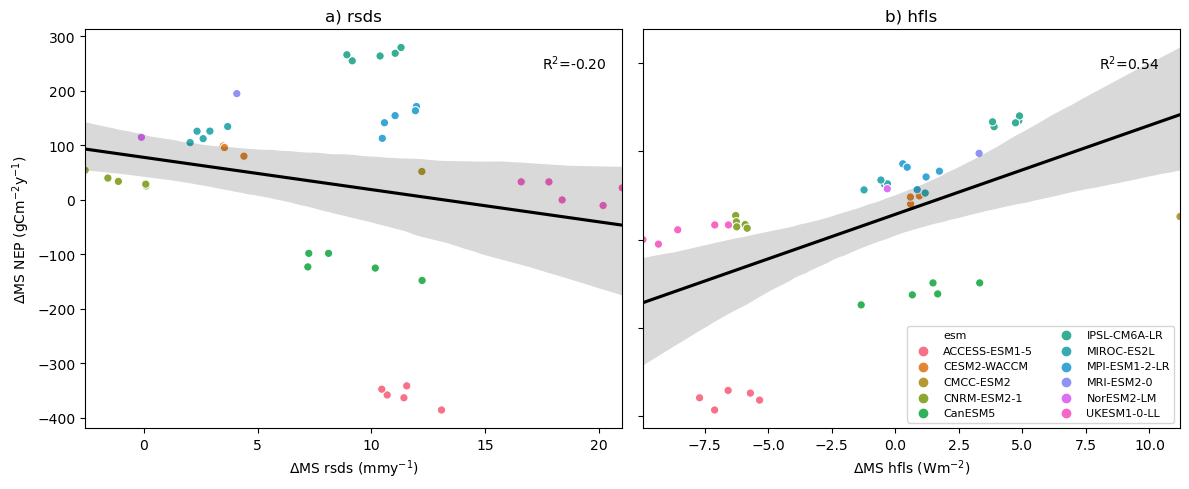

In [47]:
out_path = 'G:/Shared drives/Amazon_ENSO_work/RESULTS/'

import seaborn as sns
from scipy import stats

fig = plt.figure(figsize=(12, 5))

ax0 = fig.add_subplot(121)
ax0 = sns.scatterplot("rsds", 'nep', data=df_amz_msc, hue=df_amz_msc.index, legend = False)
ax0 = sns.regplot(x="rsds", y='nep', data=df_amz_msc, scatter=False, line_kws={"color": "black"})
ax0.set(xlabel="\u0394MS rsds (mmy$^{-1}$)", ylabel='\u0394MS NEP (gCm$^{-2}$y$^{-1}$)')
ax0.label_outer()
# ax0.legend(loc='lower right', ncol=2, fontsize = 8)
ax0.text(.85, .9, 'R$^2$={:.2f}'.format(stats.linregress(df_amz_msc['nep'],df_amz_msc["rsds"]).rvalue),
            transform=ax0.transAxes, fontsize = 10)
ax0.set_title("a) rsds")

ax = fig.add_subplot(122)
ax = sns.scatterplot("hfls", 'nep', data=df_amz_msc, hue=df_amz_msc.index)
ax = sns.regplot(x="hfls", y='nep', data=df_amz_msc, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="\u0394MS hfls (Wm$^{-2}$)", ylabel=None)
ax.label_outer()
ax.legend(loc='lower right', ncol=2, fontsize = 8)

ax.text(.85, .9, 'R$^2$={:.2f}'.format(stats.linregress(df_amz_msc['nep'],df_amz_msc["hfls"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.set_title("b) hfls")

fig.tight_layout()
title= "MSC model diversity - rsds + hfls"
output_file = os.path.join(out_path, title) + "_net.png"
plt.savefig(output_file, bbox_inches='tight')

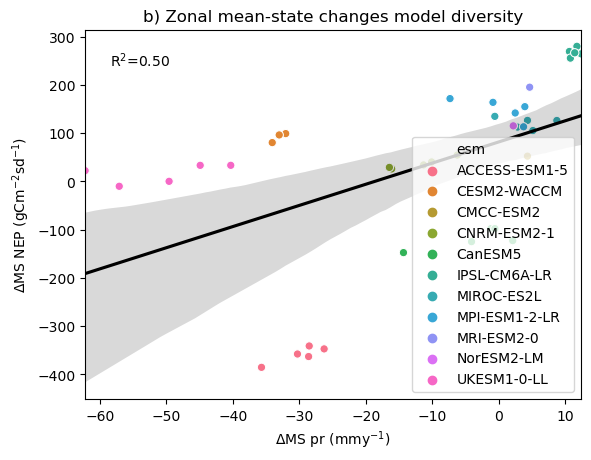

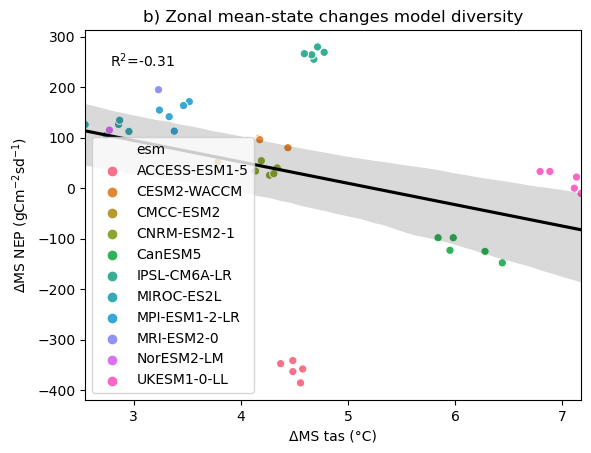

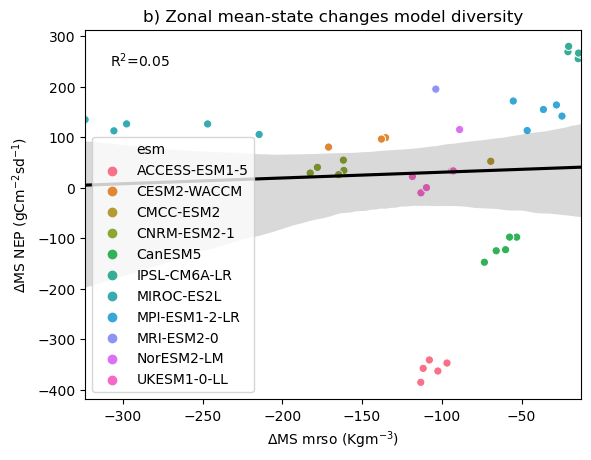

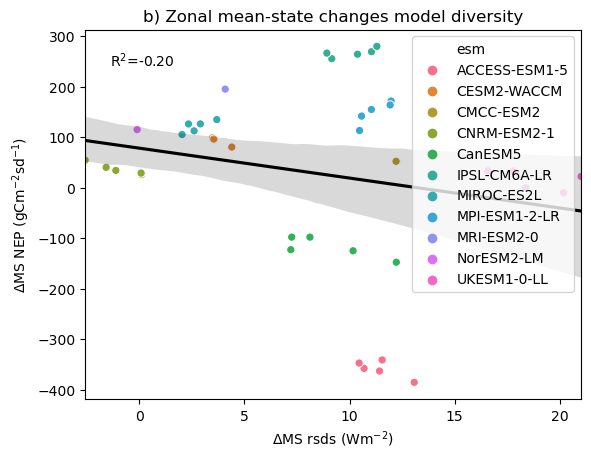

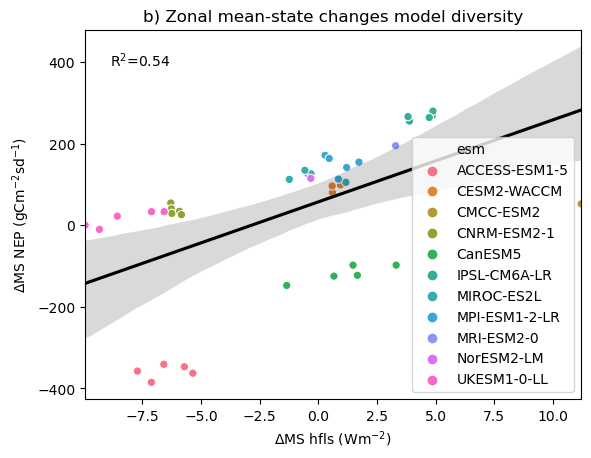

In [48]:
out_path = 'G:/Shared drives/Amazon_ENSO_work/RESULTS/'

from scipy import stats
import seaborn as sns
i = 0
units = ["mmy$^{-1}$", "°C", "Kgm$^{-3}$", "Wm$^{-2}$", "Wm$^{-2}$"]
for predictor in ["pr", "tas", "mrso", "rsds", "hfls"]:
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax = sns.scatterplot(predictor, 'nep', data=df_amz_msc, hue=df_amz_msc.index)
    ax = sns.regplot(x=predictor, y='nep', data=df_amz_msc, scatter=False, line_kws={"color": "black"})
    ax.set(xlabel="\u0394MS " + predictor + " (" + units[i] +")", ylabel='\u0394MS NEP (gCm$^{-2}$sd$^{-1}$)')
    ax.text(.05, .9, 'R$^2$={:.2f}'.format(stats.linregress(df_amz_msc['nep'],df_amz_msc[predictor]).rvalue),
            transform=ax.transAxes, fontsize = 10)
    title= "MSC model diversity - " + predictor
    ax.set_title("b) Zonal mean-state changes model diversity")
    #ax.legend(ncol=2, fontsize = 8)
    # output_file = os.path.join(out_path, title) + ".png"
#     plt.savefig(output_file, bbox_inches='tight')
    i = i+1

### Explore Emergent Constraints

In [24]:
# Zonal mean in amazon basin
ds_hfls_amz_hist = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_clim_neutral_hist_hfls]; 
ds_hfls_amz_ssp = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_clim_neutral_ssp_hfls]; 
ds_rsds_amz_hist = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_clim_neutral_hist_rsds]; 
ds_rsds_amz_ssp = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_clim_neutral_ssp_rsds]; 
ds_pr_amz_hist = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_clim_neutral_hist_pr]; 
ds_pr_amz_ssp = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_clim_neutral_ssp_pr]; 
ds_tas_amz_hist = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_clim_neutral_hist_tas]; 
ds_tas_amz_ssp = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_clim_neutral_ssp_tas]; 
ds_mrso_amz_hist = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_clim_neutral_hist_mrso]; 
ds_mrso_amz_ssp = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_clim_neutral_ssp_mrso]; 
ds_nep_amz_hist = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_clim_neutral_hist_nep]; 
ds_nep_amz_ssp = [zonal_stat(a, geodf).sel(region = 1).mean(...) for a in ds_clim_neutral_ssp_nep]; 


In [25]:
# Convert to pandas dataframe
df_nep_amz_hist =  xr.concat(ds_nep_amz_hist, dim = "esm").to_dataframe(name = "nep"); df_nep_amz_hist = df_nep_amz_hist.drop(columns = ["region"]).rename(index=dict(zip(df_nep_amz_hist.index, esm)))
df_pr_amz_hist = xr.concat(ds_pr_amz_hist, dim = "esm").to_dataframe(); df_pr_amz_hist = df_pr_amz_hist.drop(columns = ["region"]).rename(index=dict(zip(df_pr_amz_hist.index, esm)))
df_tas_amz_hist =  xr.concat(ds_tas_amz_hist, dim = "esm", coords='minimal', compat='override').to_dataframe(); df_tas_amz_hist = df_tas_amz_hist.drop(columns = ["region", "height"]).rename(index=dict(zip(df_tas_amz_hist.index, esm)))
df_mrso_amz_hist = xr.concat(ds_mrso_amz_hist, dim = "esm").to_dataframe(); df_mrso_amz_hist = df_mrso_amz_hist.drop(columns = ["region"]).rename(index=dict(zip(df_mrso_amz_hist.index, esm)))
df_hfls_amz_hist = xr.concat(ds_hfls_amz_hist, dim = "esm").to_dataframe(); df_hfls_amz_hist = df_hfls_amz_hist.drop(columns = ["region"]).rename(index=dict(zip(df_hfls_amz_hist.index, esm)))
df_rsds_amz_hist = xr.concat(ds_rsds_amz_hist, dim = "esm").to_dataframe(); df_rsds_amz_hist = df_rsds_amz_hist.drop(columns = ["region"]).rename(index=dict(zip(df_rsds_amz_hist.index, esm)))

df_nep_amz_ssp =  xr.concat(ds_nep_amz_ssp, dim = "esm").to_dataframe(name = "nep"); df_nep_amz_ssp = df_nep_amz_ssp.drop(columns = ["region"]).rename(index=dict(zip(df_nep_amz_ssp.index, esm)))
df_pr_amz_ssp = xr.concat(ds_pr_amz_ssp, dim = "esm").to_dataframe(); df_pr_amz_ssp = df_pr_amz_ssp.drop(columns = ["region"]).rename(index=dict(zip(df_pr_amz_ssp.index, esm)))
df_tas_amz_ssp =  xr.concat(ds_tas_amz_ssp, dim = "esm", coords='minimal', compat='override').to_dataframe(); df_tas_amz_ssp = df_tas_amz_ssp.drop(columns = ["region", "height"]).rename(index=dict(zip(df_tas_amz_ssp.index, esm)))
df_mrso_amz_ssp = xr.concat(ds_mrso_amz_ssp, dim = "esm").to_dataframe(); df_mrso_amz_ssp = df_mrso_amz_ssp.drop(columns = ["region"]).rename(index=dict(zip(df_mrso_amz_ssp.index, esm)))
df_hfls_amz_ssp = xr.concat(ds_hfls_amz_ssp, dim = "esm").to_dataframe(); df_hfls_amz_ssp = df_hfls_amz_ssp.drop(columns = ["region"]).rename(index=dict(zip(df_hfls_amz_ssp.index, esm)))
df_rsds_amz_ssp = xr.concat(ds_rsds_amz_ssp, dim = "esm").to_dataframe(); df_rsds_amz_ssp = df_rsds_amz_ssp.drop(columns = ["region"]).rename(index=dict(zip(df_rsds_amz_ssp.index, esm)))


In [26]:
df_amz_ms = pd.concat([df_nep_amz_hist, df_pr_amz_hist, df_tas_amz_hist, df_mrso_amz_hist, df_hfls_amz_hist, df_rsds_amz_hist, df_nep_amz_ssp, df_pr_amz_ssp, df_tas_amz_ssp, df_mrso_amz_ssp, df_hfls_amz_ssp, df_rsds_amz_ssp], axis = 1)
df_amz_ms.set_axis(["nep_hist","pr_hist","tas_hist","mrso_hist","hfls_hist","rsds_hist","nep_ssp","pr_ssp","tas_ssp","mrso_ssp","hfls_ssp","rsds_ssp"], axis=1, inplace=True)

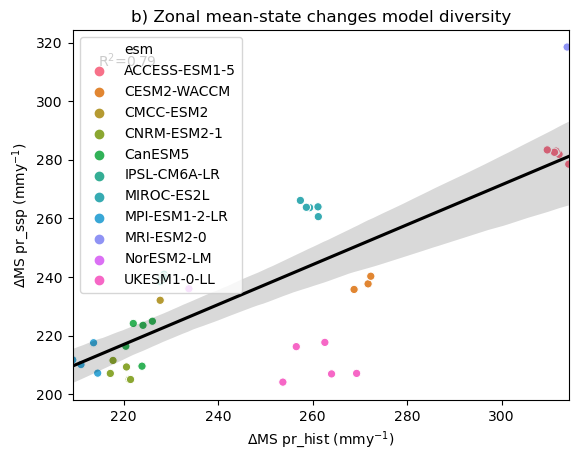

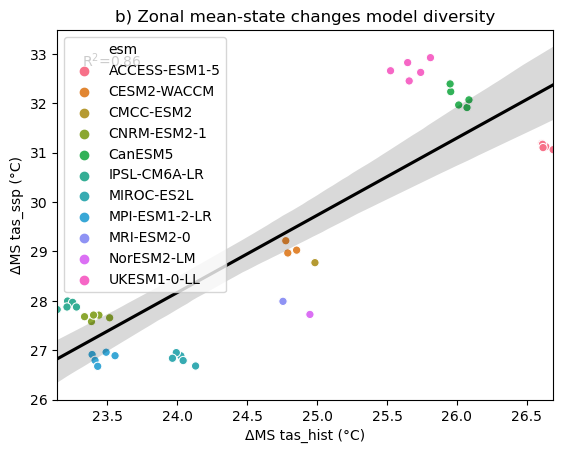

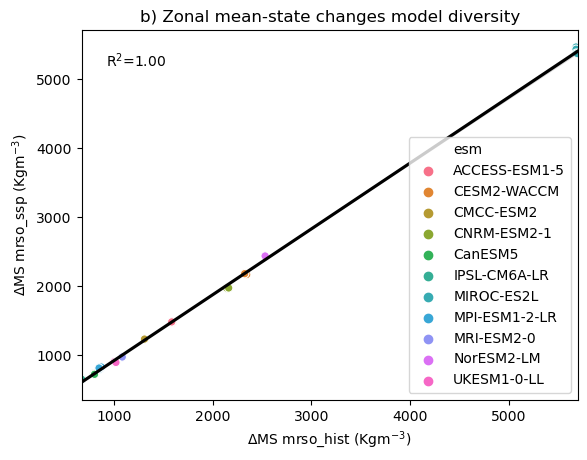

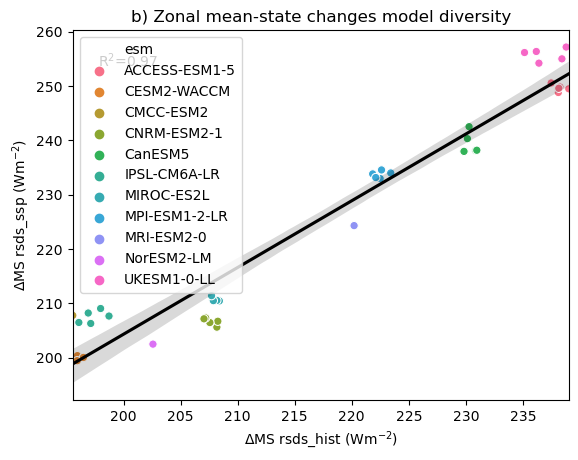

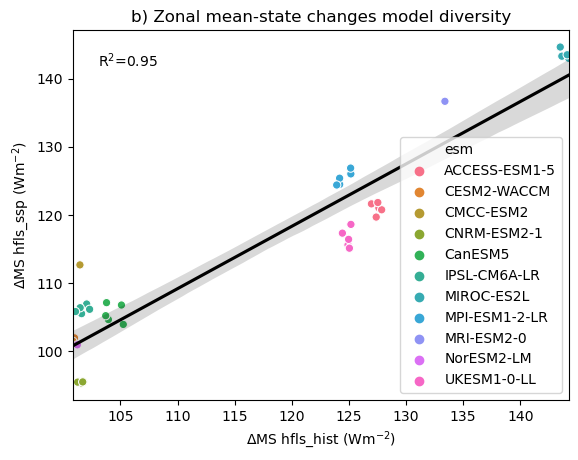

In [30]:
out_path = 'G:/Shared drives/Amazon_ENSO_work/RESULTS/'

from scipy import stats
import seaborn as sns
i = 0
units = ["mmy$^{-1}$", "°C", "Kgm$^{-3}$", "Wm$^{-2}$", "Wm$^{-2}$"]
for predictor in ["pr", "tas", "mrso", "rsds", "hfls"]:
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax = sns.scatterplot(predictor + "_hist", predictor + "_ssp", data=df_amz_ms, hue=df_amz_ms.index)
    ax = sns.regplot(x=predictor + "_hist", y = predictor + "_ssp", data=df_amz_ms, scatter=False, line_kws={"color": "black"})
    ax.set(xlabel="\u0394MS " + predictor + "_hist" + " (" + units[i] +")", ylabel="\u0394MS " + predictor + "_ssp" + " (" + units[i] +")")
    ax.text(.05, .9, 'R$^2$={:.2f}'.format(stats.linregress(df_amz_ms[predictor + "_hist"],df_amz_ms[predictor + "_ssp"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
    title= "MSC model diversity - " + predictor
    ax.set_title("b) Zonal mean-state changes model diversity")
    #ax.legend(ncol=2, fontsize = 8)
    # output_file = os.path.join(out_path, title) + ".png"
#     plt.savefig(output_file, bbox_inches='tight')
    i = i+1